<a href="https://colab.research.google.com/github/bonjon/gossipy/blob/pensattacks/PENS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/bonjon/gossipy.git

Cloning into 'gossipy'...
remote: Enumerating objects: 1408, done.
remote: Counting objects: 100% (275/275), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 1408 (delta 150), reused 135 (delta 72), pack-reused 1133
Receiving objects: 100% (1408/1408), 2.17 MiB | 4.98 MiB/s, done.
Resolving deltas: 100% (962/962), done.


In [ ]:
%cd gossipy

/content/gossipy


In [ ]:
!pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.9 MB/s eta 0:00:00


Import all stuff useful for the experiment.

In [ ]:
import torch
torch.cuda.is_available()

False

In [ ]:
from gossipy import GlobalSettings
GlobalSettings().set_device("cuda")

device(type='cuda')

In [ ]:
import math
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Compose, Normalize, RandomVerticalFlip
from gossipy.simul import GossipSimulator, SimulationReport
from gossipy.utils import choice_not_n
from gossipy.data.handler import ClassificationDataHandler
from gossipy.model.handler import ModelHandler, TorchModelHandler
from gossipy.model.sampling import TorchModelSampling
from gossipy import CACHE, LOG, set_seed
import random
import numpy as np
from numpy.random import randint, normal, rand
from numpy import ndarray
from torch import Tensor
from typing import Any, Optional, Union, Dict, Tuple, Iterable, List, Callable
from math import ceil, floor
import pickle
import networkx as nx
from networkx.generators.trees import random_tree
from networkx.generators import barabasi_albert_graph
from gossipy.data import load_classification_dataset, DataDispatcher, get_MNIST, get_FashionMNIST
import matplotlib.pyplot as plt
import copy
from gossipy.core import AntiEntropyProtocol, CreateModelMode, StaticP2PNetwork, UniformDelay
from gossipy.node import GossipNode, PENSNode
from byzantine_report import ByzantineSimulationReport
from byzantine_generate import generate_nodes, GenerationType
from gossipy.model.nn import TorchModel, TorchMLP, LogisticRegression, TorchPerceptron
from scipy.stats import norm

# Implementation of the Gaussian Attack
This function performs a Gaussian poisoning attack on a model. The attack is performed by adding a Gaussian noise vector to the model's weights.

In [ ]:
class GaussianAttackMixin(TorchModelHandler):
    '''Each update replaces the model with a Gaussian model attack.

    Parameters
    ----------
    scale: float
        The amplitude of noise
    mean: float
        Mean of weights and biases
    '''

    def __init__(self, scale: float = 1.0, mean: float = 0.0):
        self.scale = scale
        self.mean = mean

    def _update(self, data: Tuple[torch.Tensor, torch.Tensor]) -> None:
        with torch.no_grad():
            state = self.model.state_dict()
            for name in state:
                state[name] = torch.tensor(np.random.normal(self.mean, self.scale, state[name].size()))
        self.model.load_state_dict(state)
        self.n_updates += 1

class TorchGaussianAttackModelHandler(GaussianAttackMixin, TorchModelHandler):
  def __init__(self,
                 scale: float,
                 mean: float,
                 net: TorchModel,
                 optimizer: torch.optim.Optimizer,
                 optimizer_params: Dict[str, Any],
                 criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
                 local_epochs: int = 1,
                 batch_size: int = 32,
                 create_model_mode: CreateModelMode = CreateModelMode.MERGE_UPDATE,
                 copy_model=True,
                 on_device=False):
        GaussianAttackMixin.__init__(self, scale, mean)
        TorchModelHandler.__init__(self, net, optimizer, optimizer_params, criterion,
                                   local_epochs, batch_size, create_model_mode, copy_model, on_device)
        self.evaluation = None
  def evaluate(self, data: Tuple[torch.Tensor, torch.Tensor]) -> Dict[str, int]:
        self.evaluation = super().evaluate(data)
        return None

# Implementation of LIE Baruch et *al.* (2019) Attack
  This function is related to Omniscent LIE attack, Baruch et *al.* (2019). This attack lets the defender remove the non-Byzantine clients and shift the aggregation gradient by carefully crafting malicious values that deviate from the correct ones as far as possible.

In [ ]:
class LIEAttackMixin(TorchModelHandler):
    '''

    Parameters
    ----------
    n_nodes: number of network "normal" nodes
    b_nodes: number of network "byzantine" nodes
    '''

    def __init__(self, n_nodes: int, b_nodes: int):
        self.n_nodes = n_nodes
        self.b_nodes = b_nodes

    def _update(self, data: Tuple[torch.Tensor, torch.Tensor]) -> None:
        with torch.no_grad():
            state = self.model.state_dict()
            # number of supporters
            s = floor((self.n_nodes / 2) + 1) - self.b_nodes
            # initialize mean and standard deviation of parameters
            grads_mean = []
            grads_stdev = []
            for name in state:
                if name.endswith("bias"):
                    grads_mean.append(torch.mean(state[name], axis=0).repeat(state[name].shape[0]))
                    grads_stdev.append(torch.std(state[name], axis=0).repeat(state[name].shape[0]) ** 0.5)
                else:
                    grads_mean.append(torch.mean(state[name], axis=0).repeat(state[name].shape[0], 1))
                    grads_stdev.append(torch.std(state[name], axis=0).repeat(state[name].shape[0], 1) ** 0.5)
            # The algorithm
            if s < 0:
                s = 1
            z_max = norm.ppf((self.n_nodes - self.b_nodes - s) / (self.n_nodes - self.b_nodes))
            mul_std = [torch.mul(grads_stdev[i], z_max) for i in range(len(grads_stdev))]
            for i in range(len(grads_mean)):
                # clone tensor
                keys = list(state.keys())
                state[keys[i]] = (grads_mean[i] - mul_std[i]).clone().detach()

        self.model.load_state_dict(state)
        self.n_updates += 1

class TorchLIEAttackModelHandler(LIEAttackMixin, TorchModelHandler):
  def __init__(self,
                 n_nodes: int,
                 b_nodes: int,
                 net: TorchModel,
                 optimizer: torch.optim.Optimizer,
                 optimizer_params: Dict[str, Any],
                 criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
                 local_epochs: int = 1,
                 batch_size: int = 32,
                 create_model_mode: CreateModelMode = CreateModelMode.MERGE_UPDATE,
                 copy_model=True,
                 on_device=False):
        LIEAttackMixin.__init__(self, n_nodes, b_nodes)
        TorchModelHandler.__init__(self, net, optimizer, optimizer_params, criterion,
                                   local_epochs, batch_size, create_model_mode, copy_model, on_device)
        self.evaluation = None
  def evaluate(self, data: Tuple[torch.Tensor, torch.Tensor]) -> Dict[str, int]:
        self.evaluation = super().evaluate(data)
        return None

# Implementation of Fall of Empires Attack Xie et. *al.* (2019)

“Fall of empires attack” uploads the crafted
gradient where gradient = −ϵ ∗ µ. Here, µ is the mean of gradients and z is the
attack multiple; we set ϵ as 10.

In [ ]:
class FOEAttackMixin(TorchModelHandler):
    '''

    Parameters
    ----------
    n_nodes: number of network "normal" nodes
    b_nodes: number of network "byzantine" nodes
    '''

    def __init__(self, epsilon: int):
        self.epsilon = epsilon

    def _update(self, data: Tuple[torch.Tensor, torch.Tensor]) -> None:
        with torch.no_grad():
            state = self.model.state_dict()
            grads_mean = []
            for name in state:
                if name.endswith("bias"):
                    grads_mean.append(torch.mean(state[name], axis=0).repeat(state[name].shape[0]))
                else:
                    grads_mean.append(torch.mean(state[name], axis=0).repeat(state[name].shape[0], 1))
            for i in range(len(grads_mean)):
                keys = list(state.keys())
                state[keys[i]] = (grads_mean[i]*(-self.epsilon)).clone().detach()
        self.model.load_state_dict(state)
        self.n_updates += 1

class TorchFOEAttackModelHandler(FOEAttackMixin, TorchModelHandler):
  def __init__(self,
                 epsilon: int,
                 net: TorchModel,
                 optimizer: torch.optim.Optimizer,
                 optimizer_params: Dict[str, Any],
                 criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
                 local_epochs: int = 1,
                 batch_size: int = 32,
                 create_model_mode: CreateModelMode = CreateModelMode.MERGE_UPDATE,
                 copy_model=True,
                 on_device=False):
        FOEAttackMixin.__init__(self, epsilon)
        TorchModelHandler.__init__(self, net, optimizer, optimizer_params, criterion,
                                   local_epochs, batch_size, create_model_mode, copy_model, on_device)
        self.evaluation = None
  def evaluate(self, data: Tuple[torch.Tensor, torch.Tensor]) -> Dict[str, int]:
        self.evaluation = super().evaluate(data)
        return None

Plot function.

In [ ]:
def plot(evals,
                    title: str = "Untitled plot",
                    file: str = None) -> None:

    if not evals:
        return
    fig = plt.figure()
    fig.canvas.manager.set_window_title(title)
    ax = fig.add_subplot(111)
    for attack in evals:
      for key in evals[attack]:
        evs = [[d["accuracy"] for d in l] for l in evals[attack][key]]
        mu: float = np.mean(evs, axis=0)
        std: float = np.std(evs, axis=0)
        plt.fill_between(range(1, len(mu)+1), mu-std, mu+std, alpha=0.2)
        plt.title(title)
        plt.xlabel("communication rounds")
        plt.ylabel("accuracy")
        plt.plot(range(1, len(mu)+1), mu, label=str(attack) + " probability")
        k = "accuracy"
        LOG.info(f"{k}: {mu[-1]:.2f}")
        ax.legend(loc="best")

    if file != None:
        plt.savefig(file)
    else:
        plt.show()

# MNIST Test

In [ ]:
def evalMNIST(data_in, prop, aggregator, attack, gossip):
    if not data_in:
        plus = "+"
    else:
        plus = ""

    set_seed(42)
    tr, te = get_MNIST()

    data_handler = ClassificationDataHandler(
        tr[0], tr[1], te[0], te[1], on_device=True)  # X[1], y[1]
    data_dispatcher = DataDispatcher(
        data_handler, n=50, eval_on_user=False, auto_assign=True)  # Normalement n=1000

    if data_in:
        total_nb = data_dispatcher.size()
        malicious_nb = ceil(data_dispatcher.size() * prop)
        normal_nb = total_nb - malicious_nb
    else:
        total_nb = ceil(data_dispatcher.size() * (1. + prop))
        malicious_nb = total_nb - data_dispatcher.size()
        normal_nb = data_dispatcher.size()

    topology = StaticP2PNetwork(total_nb, None)
    net = TorchMLP(28*28, 10)
    model_handler = TorchModelHandler(net=net, optimizer=torch.optim.SGD,
                                      optimizer_params={
                                          "lr": 0.1
                                      }, criterion=torch.nn.CrossEntropyLoss(), on_device=True)
    if aggregator == "multi-krum":
      model_handler.set_krum(malicious_nb, "multi-krum", 1)
    elif aggregator == "median":
      model_handler.set_median("median")

    if attack == "gaussian":
      model_handler_malicious = TorchGaussianAttackModelHandler(net=net, optimizer=torch.optim.SGD, scale=1, mean=0,
                                                               optimizer_params={
                                                                   "lr": 0.1,
                                                               }, criterion=torch.nn.CrossEntropyLoss(), on_device=True)
    elif attack == "lie":
      model_handler_malicious = TorchLIEAttackModelHandler(net=net, optimizer=torch.optim.SGD, n_nodes=normal_nb, b_nodes=malicious_nb,
                                                               optimizer_params={
                                                                   "lr": 0.1,
                                                               }, criterion=torch.nn.CrossEntropyLoss(), on_device=True)
    elif attack == "foe":
      model_handler_malicious = TorchFOEAttackModelHandler(net=net, optimizer=torch.optim.SGD, epsilon=10,
                                                               optimizer_params={
                                                                   "lr": 0.1,
                                                               }, criterion=torch.nn.CrossEntropyLoss(), on_device=True)

    if gossip == True:
      r = 30
    else:
      r = 50
    # For loop to repeat the simulation
    nodes = generate_nodes(PENSNode, data_dispatcher=data_dispatcher,
                           p2p_net=topology,
                           model_proto=((normal_nb, model_handler),
                                        (malicious_nb, model_handler_malicious, data_in)),
                           round_len=100,
                           step1_rounds=r,
                           sync=False,
                           generation_type=GenerationType.NORMAL,
                           n_sampled=5)

    simulator = GossipSimulator(
        nodes=nodes,
        data_dispatcher=data_dispatcher,
        delta=100,
        protocol=AntiEntropyProtocol.PUSH,
        sampling_eval=0
    )

    report = ByzantineSimulationReport()
    simulator.add_receiver(report)
    simulator.init_nodes(seed=42)
    simulator.start(n_rounds=50)
    return [[ev for _, ev in report.get_evaluation(False)]]

# Gaussian Attack

### FedAvg

1. Gossip learning Enabled

Output()

Output()

Output()

Output()

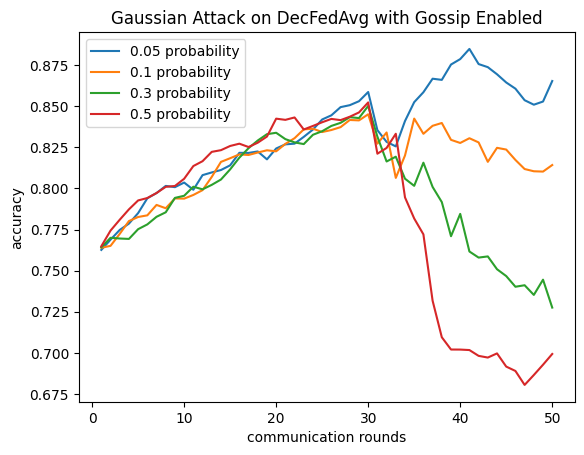

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["fedavg"]:
    evaluations[i] = evalMNIST(True, prob, i, "gaussian", True)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_fedavg_gaussian_learning.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "Gaussian Attack on DecFedAvg with Gossip Enabled", "../mnist-dec_fedavg_gaussian_learning.png")

2. Gossip learning disabled

Output()

Output()

Output()

Output()

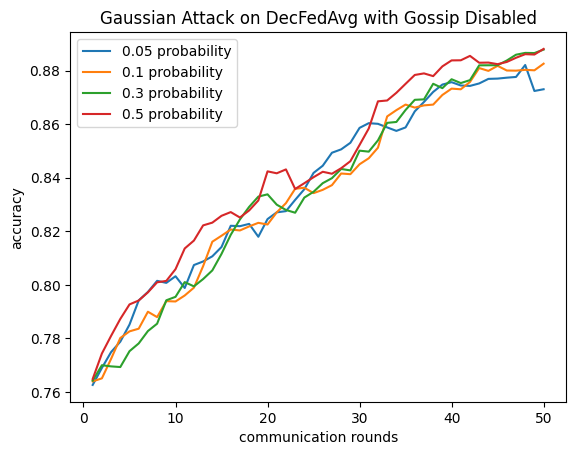

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["fedavg"]:
    evaluations[i] = evalMNIST(True, prob, i, "gaussian", False)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_fedavg_gaussian.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "Gaussian Attack on DecFedAvg with Gossip Disabled", "../mnist-dec_fedavg_gaussian.png")

### Multi-Krum

1. Gossip learning enabled

Output()

Output()

Output()

Output()

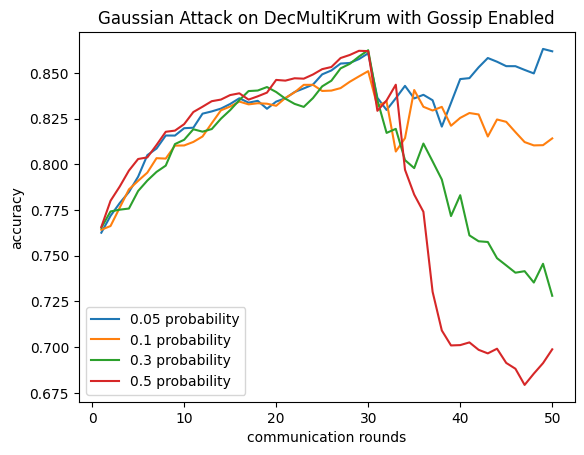

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["multi-krum"]:
    evaluations[i] = evalMNIST(True, prob, i, "gaussian", True)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_multikrum_gaussian_learning.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "Gaussian Attack on DecMultiKrum with Gossip Enabled", "../mnist-dec_multikrum_gaussian_learning.png")

2. Gossip learning disabled

Output()

Output()

Output()

Output()

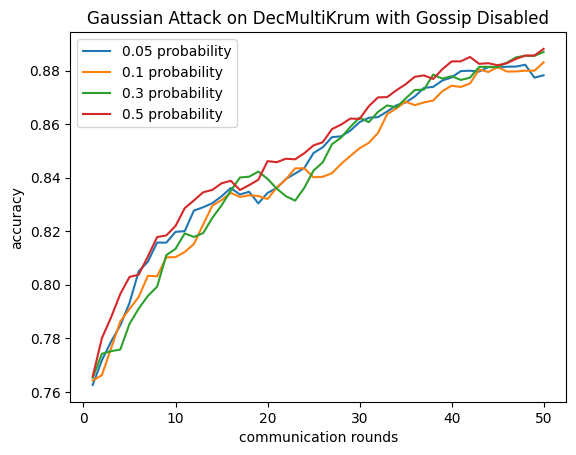

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["multi-krum"]:
    evaluations[i] = evalMNIST(True, prob, i, "gaussian", False)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_multikrum_gaussian.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "Gaussian Attack on DecMultiKrum with Gossip Disabled", "../mnist-dec_multikrum_gaussian.png")

### Median

1. Gossip learning enabled

Output()

Output()

Output()

Output()

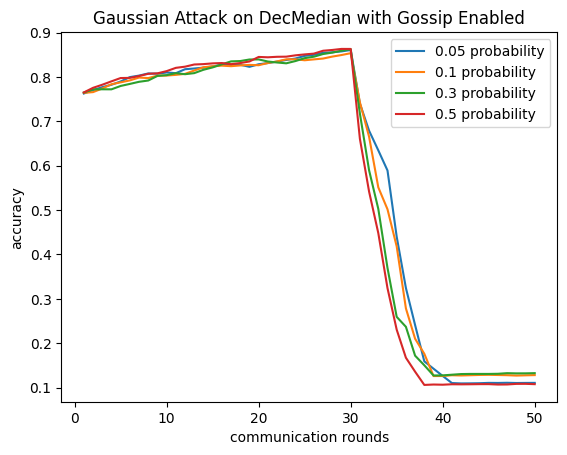

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["median"]:
    evaluations[i] = evalMNIST(True, prob, i, "gaussian", True)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_median_gaussian_learning.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "Gaussian Attack on DecMedian with Gossip Enabled", "../mnist-dec_median_gaussian_learning.png")

2. Gossip learning disabled

Output()

Output()

Output()

Output()

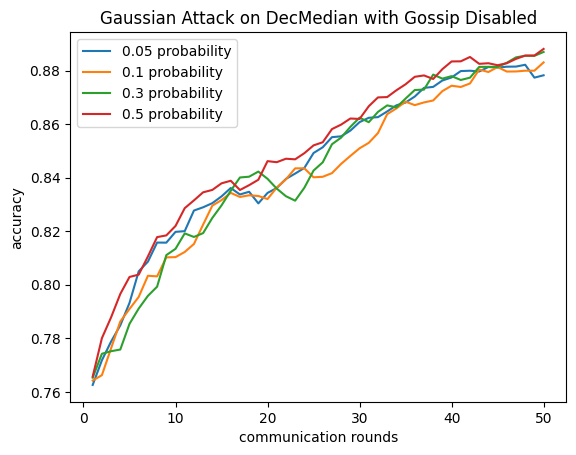

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["multi-krum"]:
    evaluations[i] = evalMNIST(True, prob, i, "gaussian", False)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_median_gaussian.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "Gaussian Attack on DecMedian with Gossip Disabled", "../mnist-dec_median_gaussian.png")

# LIE

### FedAvg

1. Gossip learning enabled

Output()

Output()

Output()

Output()

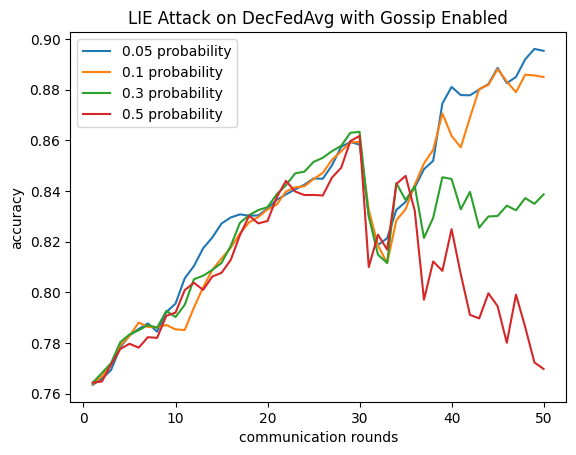

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["fedavg"]:
    evaluations[i] = evalMNIST(True, prob, i, "lie", True)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_fedavg_lie_learning.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "LIE Attack on DecFedAvg with Gossip Enabled", "../mnist-dec_fedavg_lie_learning.png")

2. Gossip learning disabled

Output()

Output()

Output()

Output()

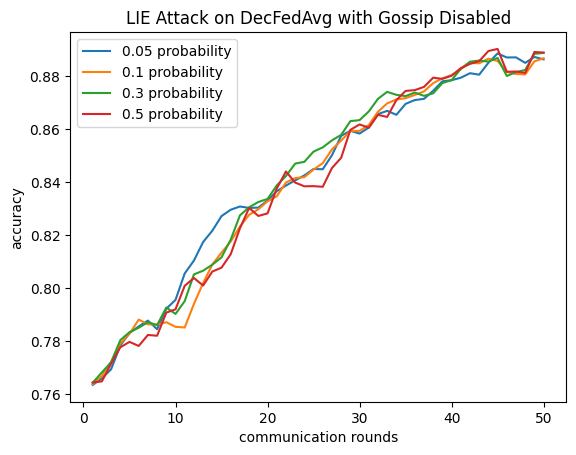

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["fedavg"]:
    evaluations[i] = evalMNIST(True, prob, i, "lie", False)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_fedavg_lie.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "LIE Attack on DecFedAvg with Gossip Disabled", "../mnist-dec_fedavg_lie.png")

### Multi-Krum

1. Gossip learning enabled

Output()

Output()

Output()

Output()

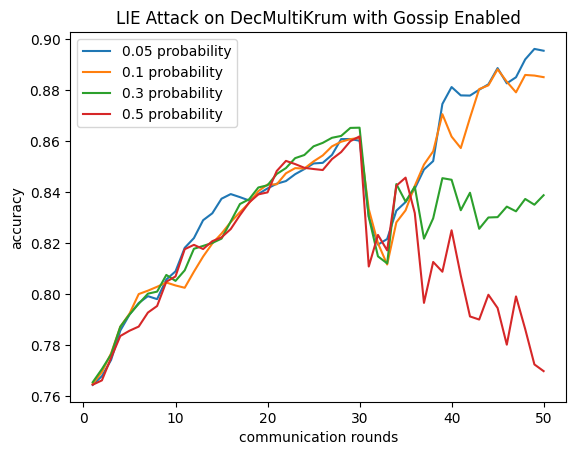

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["multi-krum"]:
    evaluations[i] = evalMNIST(True, prob, i, "lie", True)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_multikrum_lie_learning.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "LIE Attack on DecMultiKrum with Gossip Enabled", "../mnist-dec_multikrum_lie_learning.png")

2. Gossip learning disabled

Output()

Output()

Output()

Output()

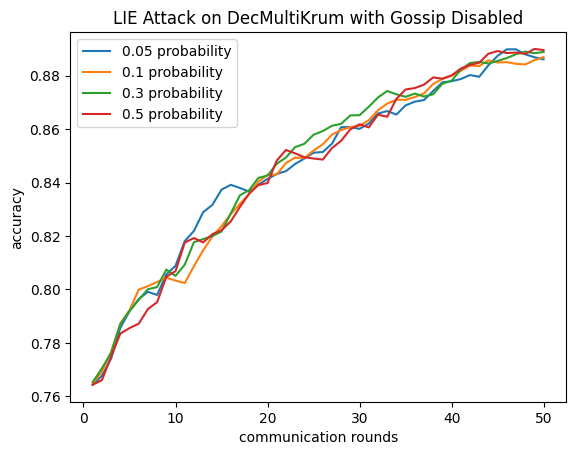

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["multi-krum"]:
    evaluations[i] = evalMNIST(True, prob, i, "lie", False)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_multikrum_lie.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "LIE Attack on DecMultiKrum with Gossip Disabled", "../mnist-dec_multikrum_lie.png")

### Median

1. Gossip learning enabled

Output()

Output()

Output()

Output()

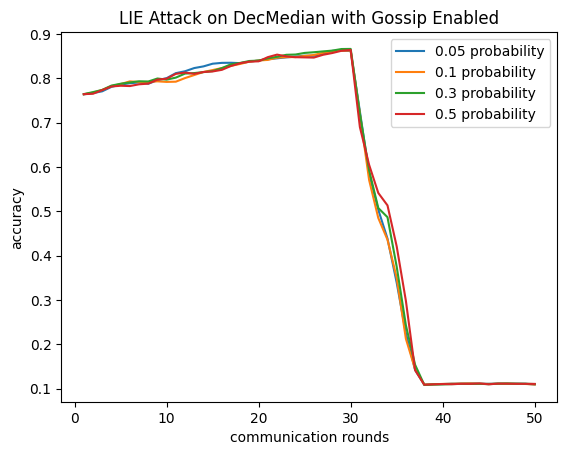

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["median"]:
    evaluations[i] = evalMNIST(True, prob, i, "lie", True)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_median_lie_learning.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "LIE Attack on DecMedian with Gossip Enabled", "../mnist-dec_median_lie_learning.png")

2. Gossip learning disabled

Output()

Output()

Output()

Output()

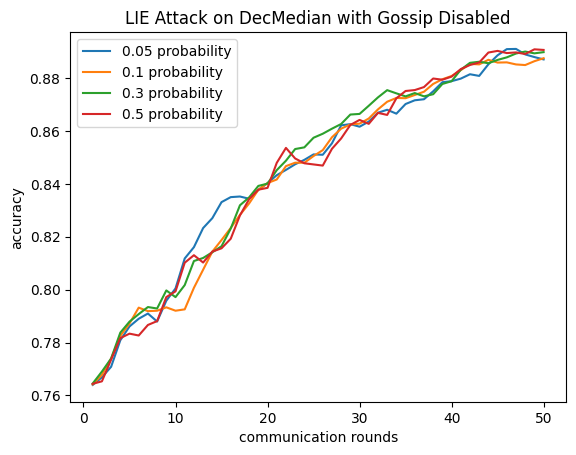

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["median"]:
    evaluations[i] = evalMNIST(True, prob, i, "lie", False)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_median_lie.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "LIE Attack on DecMedian with Gossip Disabled", "../mnist-dec_median_lie.png")

# Fall of Empires

### FedAvg

1. Gossip learning enabled

Output()

Output()

Output()

Output()

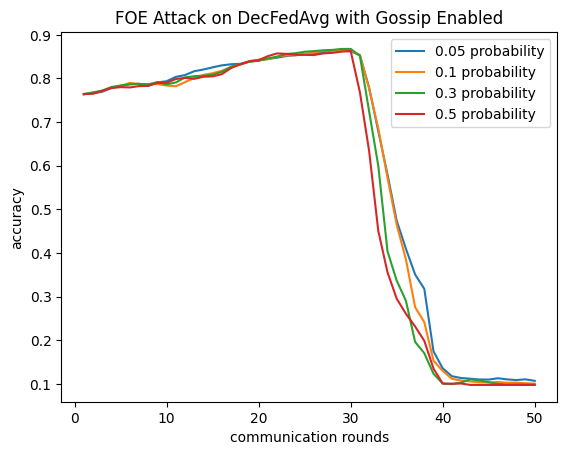

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["fedavg"]:
    evaluations[i] = evalMNIST(True, prob, i, "foe", True)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_fedavg_foe_learning.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "FOE Attack on DecFedAvg with Gossip Enabled", "../mnist-dec_fedavg_foe_learning.png")

2. Gossip learning disabled

Output()

Output()

Output()

Output()

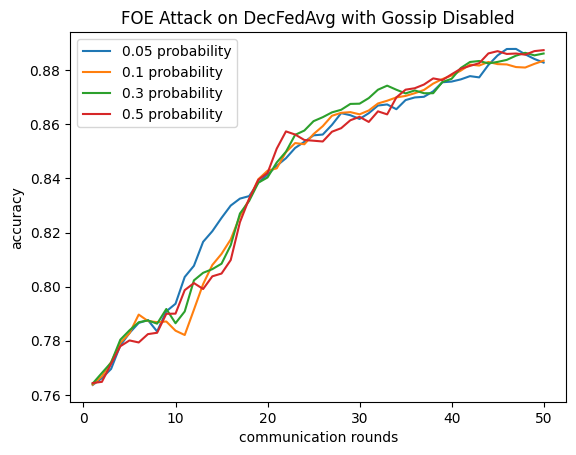

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["fedavg"]:
    evaluations[i] = evalMNIST(True, prob, i, "foe", False)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_fedavg_foe.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "FOE Attack on DecFedAvg with Gossip Disabled", "../mnist-dec_fedavg_foe.png")

### Multi-Krum

1. Gossip learning enabled

Output()

Output()

Output()

Output()

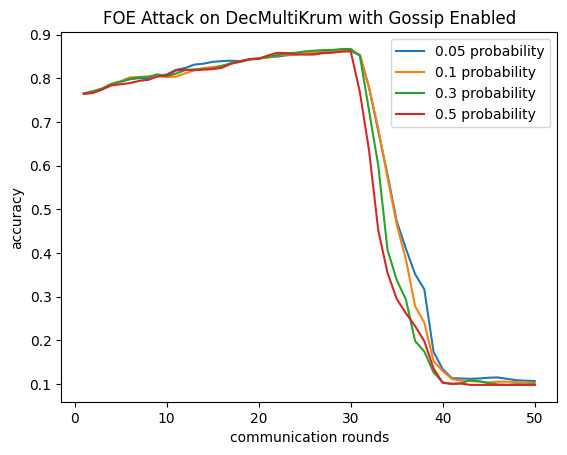

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["multi-krum"]:
    evaluations[i] = evalMNIST(True, prob, i, "foe", True)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_multikrum_foe_learning.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "FOE Attack on DecMultiKrum with Gossip Enabled", "../mnist-dec_multikrum_foe_learning.png")

2. Gossip learning disabled

Output()

Output()

Output()

Output()

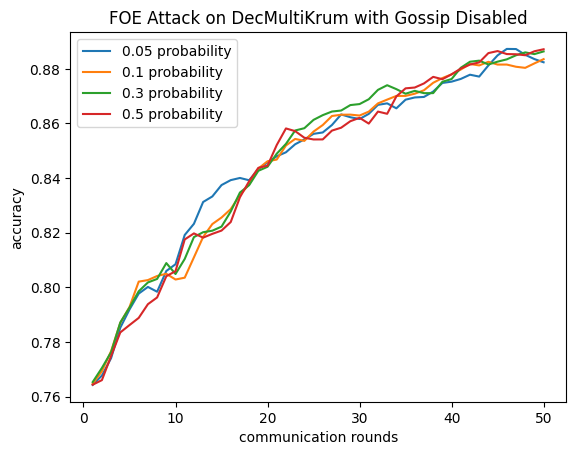

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["multi-krum"]:
    evaluations[i] = evalMNIST(True, prob, i, "foe", False)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_multikrum_foe.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "FOE Attack on DecMultiKrum with Gossip Disabled", "../mnist-dec_multikrum_foe.png")

### Median

1. Gossip learning enabled

Output()

Output()

Output()

Output()

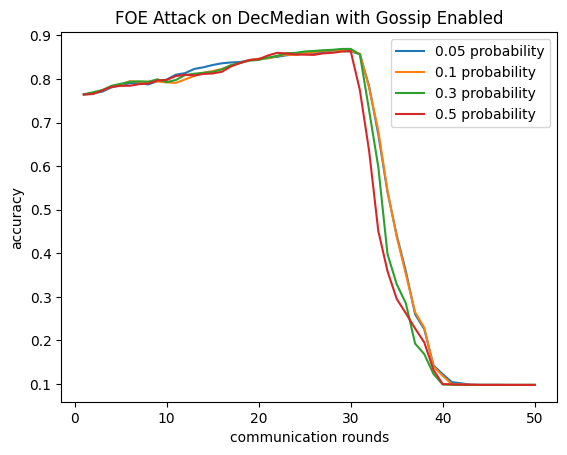

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["median"]:
    evaluations[i] = evalMNIST(True, prob, i, "foe", True)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_median_foe_learning.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "FOE Attack on DecMedian with Gossip Enabled", "../mnist-dec_median_foe_learning.png")

2. Gossip learning disabled

Output()

Output()

Output()

Output()

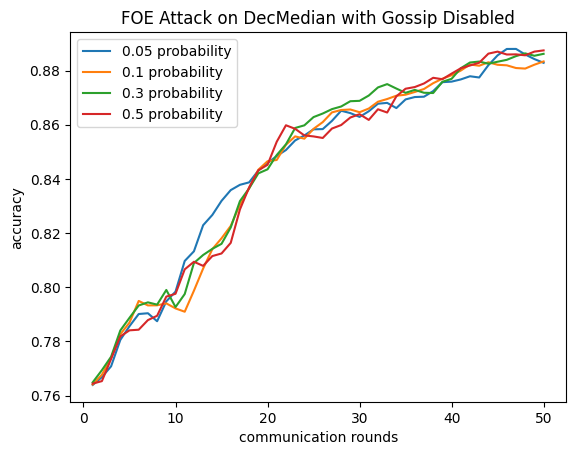

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["median"]:
    evaluations[i] = evalMNIST(True, prob, i, "foe", False)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_median_foe.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "FOE Attack on DecMedian with Gossip Disabled", "../mnist-dec_median_foe.png")

# Fashion-MNIST test

In [ ]:
def evalFashionMNIST(data_in, prop, aggregator, attack, gossip):
    if not data_in:
        plus = "+"
    else:
        plus = ""

    set_seed(42)
    tr, te = get_FashionMNIST(cnn=False)

    data_handler = ClassificationDataHandler(
        tr[0], tr[1], te[0], te[1], on_device=True)  # X[1], y[1]
    data_dispatcher = DataDispatcher(
        data_handler, n=50, eval_on_user=False, auto_assign=True)  # Normalement n=1000

    if data_in:
        total_nb = data_dispatcher.size()
        malicious_nb = ceil(data_dispatcher.size() * prop)
        normal_nb = total_nb - malicious_nb
    else:
        total_nb = ceil(data_dispatcher.size() * (1. + prop))
        malicious_nb = total_nb - data_dispatcher.size()
        normal_nb = data_dispatcher.size()

    topology = StaticP2PNetwork(total_nb, None)
    net = TorchMLP(28*28, 10)
    model_handler = TorchModelHandler(net=net, optimizer=torch.optim.Adam,
                                      optimizer_params={
                                          "lr": 0.0001
                                      }, criterion=torch.nn.CrossEntropyLoss(), on_device=True)
    if aggregator == "multi-krum":
      model_handler.set_krum(malicious_nb, "multi-krum", 1)
    elif aggregator == "median":
      model_handler.set_median("median")

    if attack == "gaussian":
      model_handler_malicious = TorchGaussianAttackModelHandler(net=net, optimizer=torch.optim.Adam, scale=1, mean=0,
                                                               optimizer_params={
                                                                   "lr": 0.0001,
                                                               }, criterion=torch.nn.CrossEntropyLoss(), on_device=True)
    elif attack == "lie":
      model_handler_malicious = TorchLIEAttackModelHandler(net=net, optimizer=torch.optim.Adam, n_nodes=normal_nb, b_nodes=malicious_nb,
                                                               optimizer_params={
                                                                   "lr": 0.0001,
                                                               }, criterion=torch.nn.CrossEntropyLoss(), on_device=True)
    elif attack == "foe":
      model_handler_malicious = TorchFOEAttackModelHandler(net=net, optimizer=torch.optim.Adam, epsilon=10,
                                                               optimizer_params={
                                                                   "lr": 0.0001,
                                                               }, criterion=torch.nn.CrossEntropyLoss(), on_device=True)
    # For loop to repeat the simulation
    nodes = generate_nodes(PENSNode, data_dispatcher=data_dispatcher,
                           p2p_net=topology,
                           model_proto=((normal_nb, model_handler),
                                        (malicious_nb, model_handler_malicious, data_in)),
                           round_len=100,
                           step1_rounds=50,
                           sync=False,
                           generation_type=GenerationType.NORMAL,
                           n_sampled=5)

    simulator = GossipSimulator(
        nodes=nodes,
        data_dispatcher=data_dispatcher,
        delta=100,
        protocol=AntiEntropyProtocol.PUSH,
        sampling_eval=0
    )

    report = ByzantineSimulationReport()
    simulator.add_receiver(report)
    simulator.init_nodes(seed=42)
    simulator.start(n_rounds=50)
    return [[ev for _, ev in report.get_evaluation(False)]]

# Gaussian Attack

### FedAvg

100%|██████████| 26421880/26421880 [00:02<00:00, 12473278.18it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 206466.92it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3696461.03it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15238021.87it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Output()

Output()

Output()

Output()

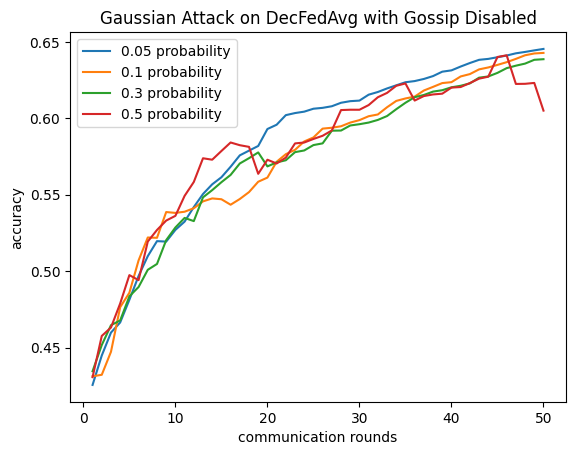

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["fedavg"]:
    evaluations[i] = evalFashionMNIST(True, prob, i, "gaussian", False)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_fed_avg_gaussian.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "Gaussian Attack on DecFedAvg with Gossip Disabled", "../fashion-mnist-dec-fedavg-gaussian.png")

### Multi-Krum

Output()

Output()

Output()

Output()

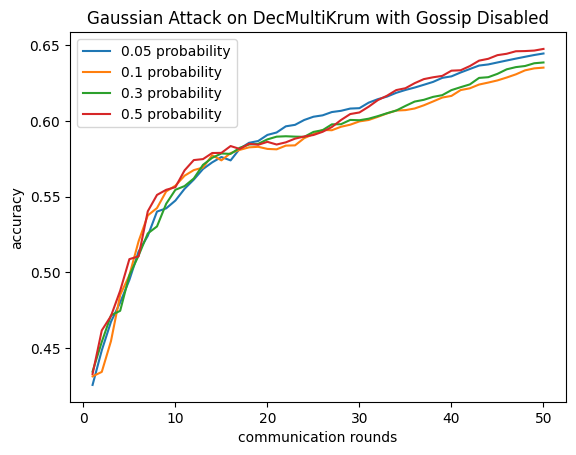

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["multi-krum"]:
    evaluations[i] = evalFashionMNIST(True, prob, i, "gaussian", False)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_multi_krum_gaussian.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "Gaussian Attack on DecMultiKrum with Gossip Disabled", "../fashion-mnist-dec-multikrum-gaussian.png")

### Median

Output()

Output()

Output()

Output()

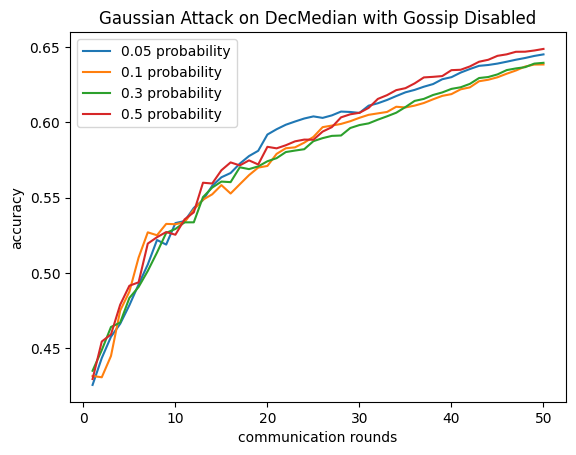

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["median"]:
    evaluations[i] = evalFashionMNIST(True, prob, i, "gaussian", False)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_median_gaussian.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "Gaussian Attack on DecMedian with Gossip Disabled", "../fashion-mnist-dec-median-gaussian.png")

# LIE Attack

### FedAvg

Output()

Output()

Output()

Output()

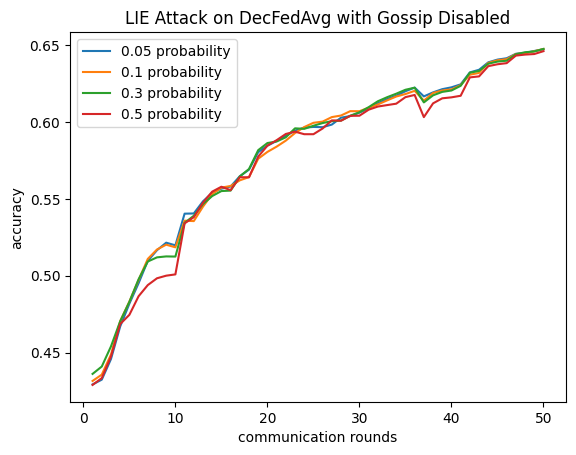

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["fedavg"]:
    evaluations[i] = evalFashionMNIST(True, prob, i, "lie", False)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_fed_avg_lie.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "LIE Attack on DecFedAvg with Gossip Disabled", "../mnist-dec-fedavg-lie.png")

### Multi-Krum

Output()

Output()

Output()

Output()

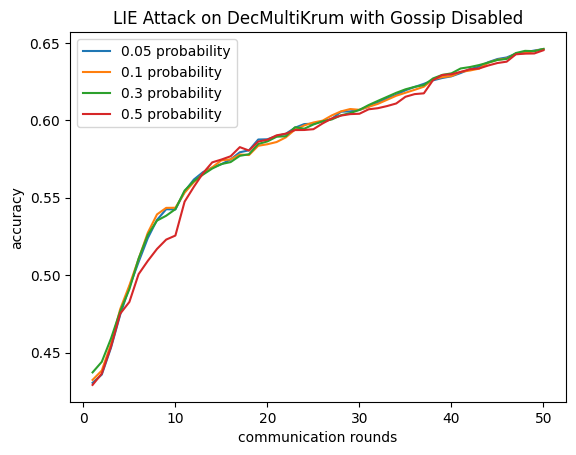

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["multi-krum"]:
    evaluations[i] = evalFashionMNIST(True, prob, i, "lie", False)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_multi_krum_lie.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "LIE Attack on DecMultiKrum with Gossip Disabled", "../mnist-dec-multikrum-lie.png")

### Median

Output()

Output()

Output()

Output()

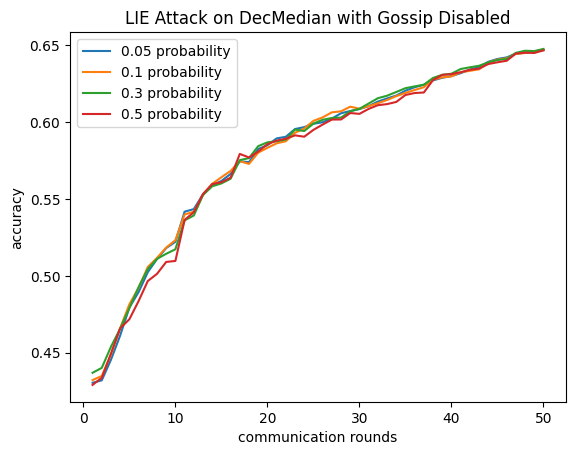

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["median"]:
    evaluations[i] = evalFashionMNIST(True, prob, i, "lie", False)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_median_lie.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "LIE Attack on DecMedian with Gossip Disabled", "../mnist-dec-median-lie.png")

# FOE Attack

### FedAvg

Output()

Output()

Output()

Output()

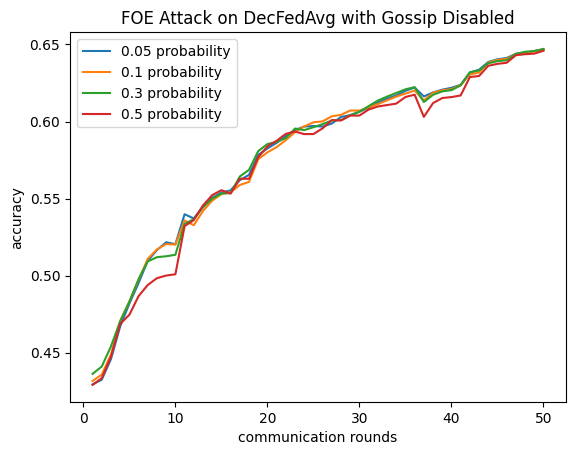

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["fedavg"]:
    evaluations[i] = evalFashionMNIST(True, prob, i, "foe", False)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_fed_avg_foe.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "FOE Attack on DecFedAvg with Gossip Disabled", "../mnist-dec-fedavg-foe.png")

### Multi-Krum

Output()

Output()

Output()

Output()

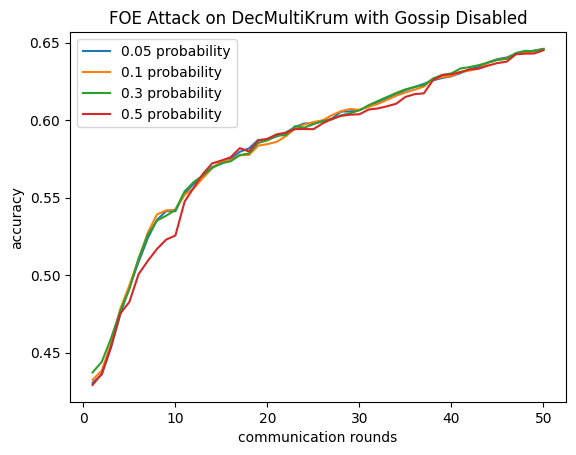

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["multi-krum"]:
    evaluations[i] = evalFashionMNIST(True, prob, i, "foe", False)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_multi_krum_foe.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "FOE Attack on DecMultiKrum with Gossip Disabled", "../mnist-dec-multikrum-foe.png")

### Median

Output()

Output()

Output()

Output()

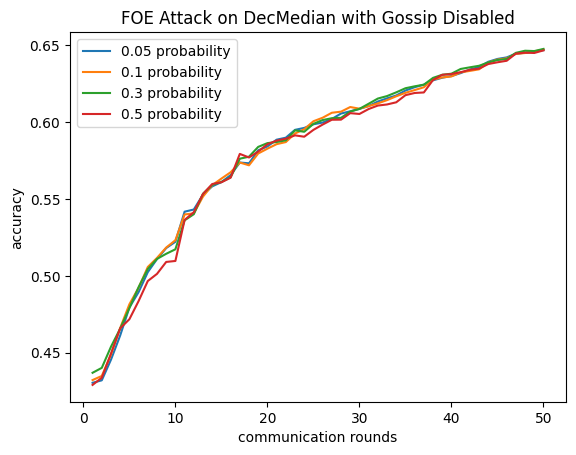

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["median"]:
    evaluations[i] = evalFashionMNIST(True, prob, i, "foe", False)
    dicts = evaluations[i][0]
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_median_foe.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "FOE Attack on DecMedian with Gossip Disabled", "../mnist-dec-median-foe.png")

# Spambase test

In [ ]:
def evalSpamBase(data_in, prop, aggregator, attack, gossip):
    if not data_in:
        plus = "+"
    else:
        plus = ""

    set_seed(42)
    tr, te = load_classification_dataset("spambase", as_tensor=True)

    data_handler = ClassificationDataHandler(
        tr, te, on_device=True)  # X[1], y[1]

    data_dispatcher = DataDispatcher(
        data_handler, n=50, eval_on_user=False, auto_assign=True)  # Normalement n=1000


    if data_in:
        total_nb = data_dispatcher.size()
        malicious_nb = ceil(data_dispatcher.size() * prop)
        normal_nb = total_nb - malicious_nb
    else:
        total_nb = ceil(data_dispatcher.size() * (1. + prop))
        malicious_nb = total_nb - data_dispatcher.size()
        normal_nb = data_dispatcher.size()

    topology = StaticP2PNetwork(total_nb, None)
    net = LogisticRegression(data_handler.Xtr.shape[1], 2)
    model_handler = TorchModelHandler(net=net, optimizer=torch.optim.SGD,
                                      optimizer_params={
                                          "lr": 0.1
                                      }, criterion=torch.nn.CrossEntropyLoss(), on_device=True)
    if aggregator == "multi-krum":
      model_handler.set_krum(malicious_nb, "multi-krum", 1)

    elif aggregator == "median":
      model_handler.set_median("median")

    if attack == "gaussian":
      model_handler_malicious = TorchGaussianAttackModelHandler(net=net, optimizer=torch.optim.SGD, scale=1, mean=0,
                                                               optimizer_params={
                                                                   "lr": 0.1
                                                               }, criterion=torch.nn.CrossEntropyLoss(), on_device=True)
    elif attack == "lie":
      model_handler_malicious = TorchLIEAttackModelHandler(net=net, optimizer=torch.optim.SGD, n_nodes=normal_nb, b_nodes=malicious_nb,
                                                               optimizer_params={
                                                                  "lr": 0.1
                                                               }, criterion=torch.nn.CrossEntropyLoss(), on_device=True)


    elif attack == "foe":
      model_handler_malicious = TorchFOEAttackModelHandler(net=net, optimizer=torch.optim.SGD, epsilon=10,
                                                               optimizer_params={
                                                                   "lr": 0.1
                                                               }, criterion=torch.nn.CrossEntropyLoss(), on_device=True)

    if gossip == True:
      r = 30
    else:
      r = 50

    # For loop to repeat the simulation
    nodes = generate_nodes(PENSNode, data_dispatcher=data_dispatcher,
                           p2p_net=topology,
                           model_proto=((normal_nb, model_handler),
                                        (malicious_nb, model_handler_malicious, data_in)),
                           round_len=100,
                           sync=False,
                           generation_type=GenerationType.NORMAL,
                           step1_rounds=r,
                           n_sampled=5)

    simulator = GossipSimulator(
        nodes=nodes,
        data_dispatcher=data_dispatcher,
        delta=100,
        protocol=AntiEntropyProtocol.PUSH,
        sampling_eval=0
    )

    report = ByzantineSimulationReport()
    simulator.add_receiver(report)
    simulator.init_nodes(seed=42)
    simulator.start(n_rounds=50)
    return [[ev for _, ev in report.get_evaluation(False)]]

# Gaussian Attack

### FedAvg

Output()

Output()

Output()

Output()

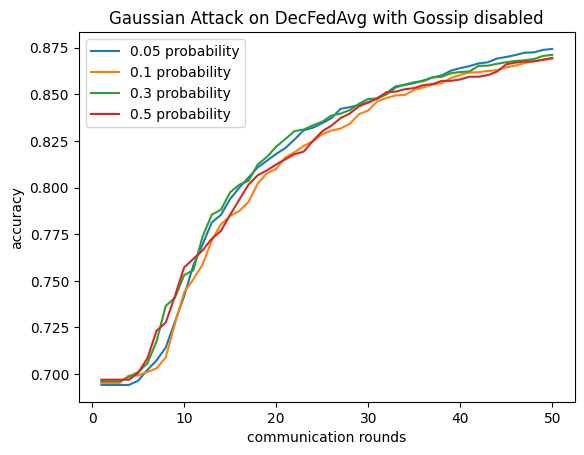

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["fedavg"]:
    evaluations[i] = evalSpamBase(True, prob, i, "gaussian", False)
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_fed_avg_gaussian.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "Gaussian Attack on DecFedAvg with Gossip disabled", "../spambase-fed-avg-gaussian.png")

### Multi-Krum

Output()

Output()

Output()

Output()

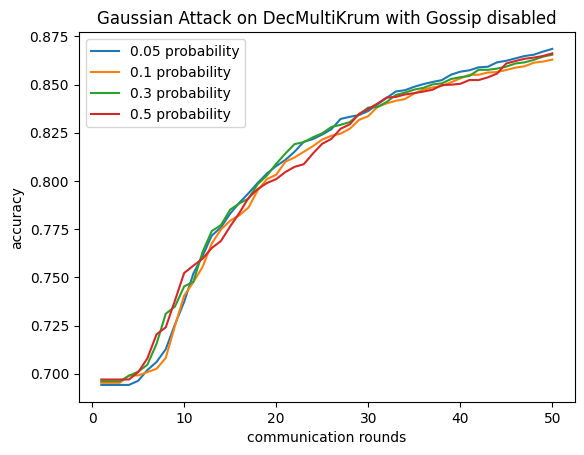

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["multi-krum"]:
    evaluations[i] = evalSpamBase(True, prob, i, "gaussian", False)
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_multi_krum_gaussian.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "Gaussian Attack on DecMultiKrum with Gossip disabled", "../spambase-multi-krum-gaussian.png")

### Median

Output()

Output()

Output()

Output()

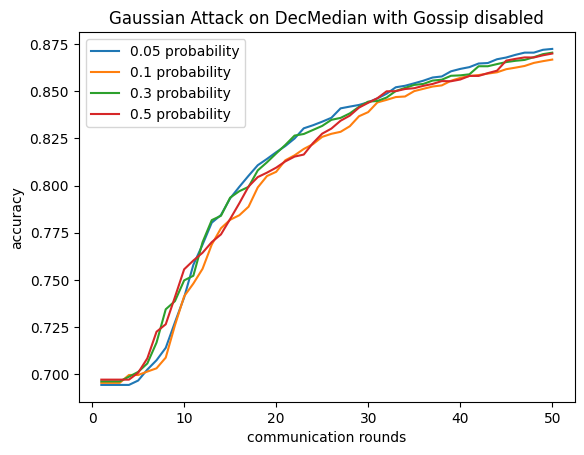

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["median"]:
    evaluations[i] = evalSpamBase(True, prob, i, "gaussian", False)
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_median_gaussian.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "Gaussian Attack on DecMedian with Gossip disabled", "../spambase-median-gaussian.png")

# LIE Attack

### FedAvg

Output()

Output()

Output()

Output()

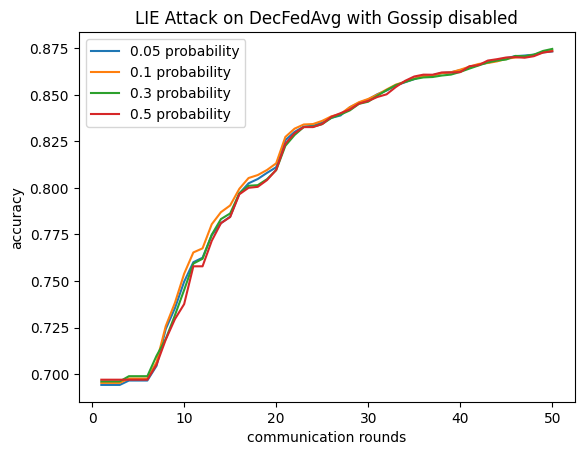

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["fedavg"]:
    evaluations[i] = evalSpamBase(True, prob, i, "lie", False)
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_fed_avg_lie.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "LIE Attack on DecFedAvg with Gossip disabled", "../spambase-fed-avg-lie.png")

### Multi-Krum

Output()

Output()

Output()

Output()

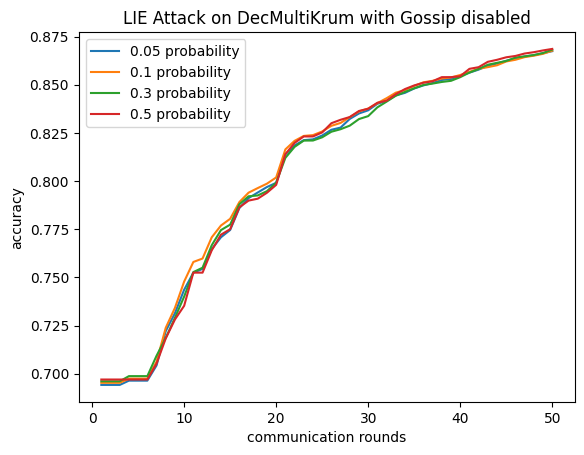

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["multi-krum"]:
    evaluations[i] = evalSpamBase(True, prob, i, "lie", False)
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_multi_krum_lie.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "LIE Attack on DecMultiKrum with Gossip disabled", "../spambase-multi-krum-lie.png")

### Median

Output()

Output()

Output()

Output()

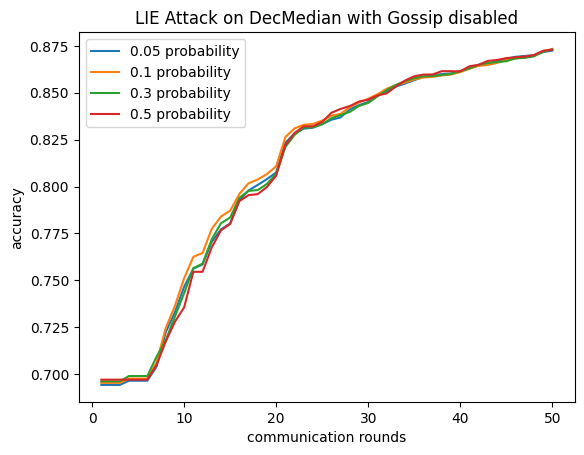

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["median"]:
    evaluations[i] = evalSpamBase(True, prob, i, "lie", False)
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_median_lie.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "LIE Attack on DecMedian with Gossip disabled", "../spambase-median-lie.png")

# FOE Attack

### FedAvg

Output()

Output()

Output()

Output()

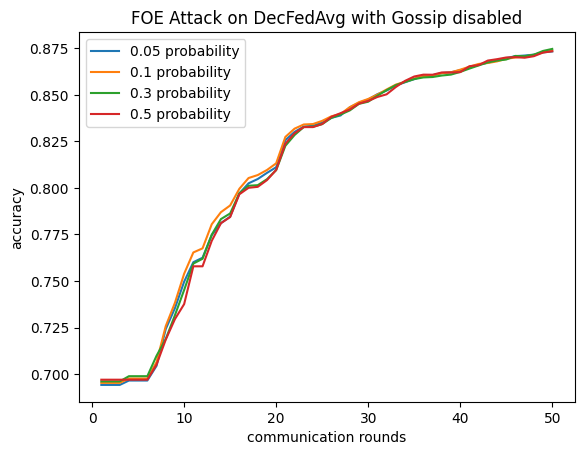

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["fedavg"]:
    evaluations[i] = evalSpamBase(True, prob, i, "foe", False)
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_fed_avg_foe.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "FOE Attack on DecFedAvg with Gossip disabled", "../spambase-fed-avg-foe.png")

### Multi-Krum

Output()

Output()

Output()

Output()

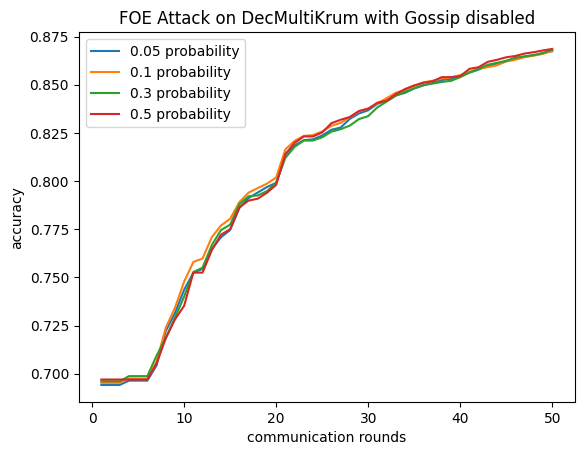

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["multi-krum"]:
    evaluations[i] = evalSpamBase(True, prob, i, "foe", False)
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_multi_krum_foe.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "FOE Attack on DecMultiKrum with Gossip disabled", "../spambase-multi-krum-foe.png")

### Median

Output()

Output()

Output()

Output()

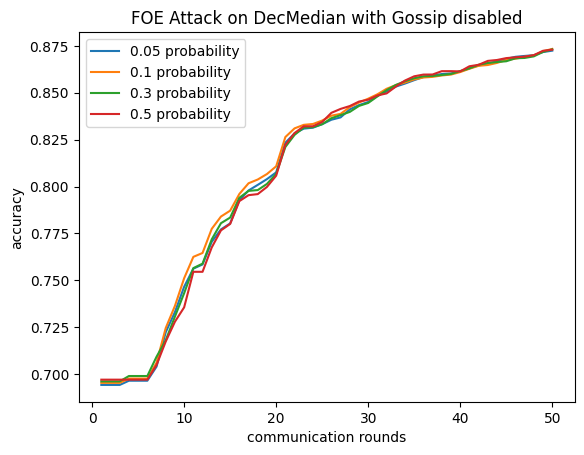

In [ ]:
evaluations = {}
attacks = {}
for prob in [0.05, 0.1, 0.3, 0.5]:
  for i in ["median"]:
    evaluations[i] = evalSpamBase(True, prob, i, "foe", False)
  attacks[prob] = evaluations
  evaluations = {}
with open("../dec_median_foe.pickle", "wb") as file:
        pickle.dump(attacks, file)
plot(attacks, "FOE Attack on DecMedian with Gossip disabled", "../spambase-median-foe.png")